<a href="https://colab.research.google.com/github/Sahilvohra58/SkimLit/blob/main/SkimLit_With_Documentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The **SkimLit** project aims to do text classification of text for parts of abstracts of research papers.

The project aimn on building machine learning and deep learning models that can produce comparable results to [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071) 


The dataset consists of around 200,000 example of abstracts collected from different research papers. 

Every abstract recorsd has sentences that belong to either of these categories:


1.   **OBJECTIVE**
2.   **METHODS**
3.   **RESULTS**
4. **CONCLUSIONS**
5. **BACKGROUND**

The project aims to classify each sentence into either of these sentences.


**1. Downloading the dataset**

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git #will clone the repo

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.


In [2]:
#Exploring the directory after cloning
!ls pubmed-rct
print()
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md

dev.txt  test.txt  train.txt


There are four directories within what was downloaded.

- 20K is just the 10% data of the main 200K data.
- Each of them has a copy of with numbers inside the text replaced with @ sign.


**2. Data exploration**

In [3]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/" #Using small dataset for smaller machine learning model

In [4]:
import os

#collect paths to all file inside the smaller dataset
filenames = [data_dir+filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [5]:
#lets open one of the files
def get_lines(file_path):
  with open(file_path, 'r') as f:
    return f.readlines()

raw_sample = get_lines(filenames[0])
raw_sample[:15]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n',
 'METHODS\tPrimary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .\n',
 'RESULTS\tSixty-five patients were randomized .

**Observations**: 
- The abstracts are sepearted from each other with some unique ID (begins with ###)
- The label of each line is in the beginning (seperated by \\t)
- Each line has \\n at its end.
- Each abstract ends with \\n


In [6]:
import numpy as np
a =np.full(5,2)
a

array([2, 2, 2, 2, 2])

In order to convert this data into usable form for the machine learning its better to write a function so that it can be applied on training, test and validation data.

In [7]:
import re
import numpy as np
import pandas as pd
import itertools

def preprocessing_raw_to_dataframe(path):
  lines = get_lines(path)
  line_count = 0
  previous_index = 1
  data = []
  lenght_counter = []
  for line in lines:
    if line.startswith('###'):
      abstract_ID = line.splitlines()[0]
    elif len(re.compile(r'^\w').findall(line)) != 0:
      line_split = line.split('\t')
      label = line_split[0]
      text = line_split[1].splitlines()[0]
      data.append([label, text, line_count])
      line_count += 1
    else:    
      temp_zeros = np.full(line_count, line_count-1)
      lenght_counter.append(temp_zeros.tolist())
      line_count = 0
    
  data = pd.DataFrame(data, columns = ['labels', 'Text', 'Line_number'])
  merged = list(itertools.chain(*lenght_counter))
  data['total_lines'] = merged
  
  return data

In [8]:
test_df = preprocessing_raw_to_dataframe(filenames[0])
train_df = preprocessing_raw_to_dataframe(filenames[1])
val_df = preprocessing_raw_to_dataframe(filenames[2]) 

Processed data

In [9]:
train_df.head()

,labels,Text,Line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11


In [10]:
train_df.labels.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: labels, dtype: int64

Plotting for data exploration

Distribution of length of abstracts


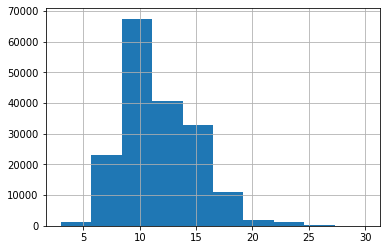

In [11]:
print('Distribution of length of abstracts')
train_df.total_lines.hist(); #length of each atstract record

Distribution of lenght of lines for each line in abstracts


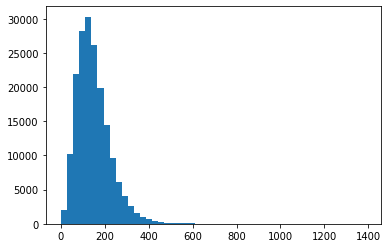

In [12]:
import matplotlib.pyplot as plt
print('Distribution of lenght of lines for each line in abstracts')
text_length_list = [len(line) for line in train_df.Text]
plt.hist(text_length_list, bins = 50)
plt.show()

Seperating text sentences from labels for further train-test split

In [13]:
train_sentences = train_df['Text'].tolist()
val_sentences = val_df['Text'].tolist()
test_sentences = test_df['Text'].tolist()

In [14]:
train_sentences[:5]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .']

Encoding labels: We will need to encode in both one hot and label encoding for evaluation purpose.

In [15]:
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder(sparse=False)

train_onehot_labels = onehotencoder.fit_transform(train_df['labels'].to_numpy().reshape(-1,1))
val_onehot_labels = onehotencoder.transform(val_df['labels'].to_numpy().reshape(-1,1))
test_onehot_labels = onehotencoder.transform(test_df['labels'].to_numpy().reshape(-1,1))

In [16]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

train_labenc_labels = labelencoder.fit_transform(train_df['labels'].to_numpy())
val_labenc_labels = labelencoder.transform(val_df['labels'].to_numpy())
test_labenc_labels = labelencoder.transform(test_df['labels'].to_numpy())

Now that our data is in a dataframe, it is better to define a strategy of experiments. Initial experiments should be on smaller models trained on small dataset and viceversa for later ones.

**3. Experiment strategy**
1. Model 0: Naive Bayes - Tfidf Multinomial.
2. Model 1: Small deep learning model with work tokenization and embedding.
3. Model 2: Using pretrained embedding (transfer learning).
4. Model 3: Deep learning with character tokenization and embedding.
4. Model 4: Deep learning with word (transfer learning) and character tokenization and embedding.
5. Model 5: Deep learning with word (transfer learning), character and positional embedding.

**Model 0: Naive Bayes - Tfidf Multinomial**

In [17]:
# importing libraries and building pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

model_0 = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())                    
                    ])
model_0.fit(X = train_sentences, y = train_labenc_labels)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [18]:
#Accuracy score was 67%
print(f"accuracy = {model_0.score(X = val_sentences, y = val_labenc_labels)}")

accuracy = 0.716674962667994


In [19]:
#Making predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([2, 2, 2, ..., 4, 4, 4])

In [20]:
#Defining score calculation function so that it can be used for further models.
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_scores(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [21]:
model_0_results = calculate_scores(val_labenc_labels, baseline_preds)
model_0_results

{'accuracy': 71.6674962667994,
 'f1': 0.6925101703856846,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994}

**Model 1: Small deep learning model with work tokenization and embedding**

- Only 10% of training data used.




In [22]:
#Finding a sequence length that convers 95% of the training samples
output_sequence_length = int(np.percentile([len(sent.split()) for sent in train_sentences], 95))
output_sequence_length

55

In [23]:
#Forming a text vectorization layer and adapting it to the training samples
from tensorflow.keras.layers import TextVectorization

textvectorization_model_1 = TextVectorization(
    max_tokens=68000, standardize='lower_and_strip_punctuation',
    output_sequence_length=output_sequence_length)

textvectorization_model_1.adapt(train_sentences)

In [24]:
#Forming an embedding layer
from tensorflow.keras.layers import Embedding

embedding_model_1 = Embedding(
    input_dim = len(textvectorization_model_1.get_vocabulary()), 
    output_dim = 128, mask_zero=True, 
    input_length=output_sequence_length)

Lets vectorize sentences in order to use later

In [25]:
train_vec_sentences = textvectorization_model_1(train_sentences)
test_vec_sentences = textvectorization_model_1(test_sentences)
val_vec_sentences = textvectorization_model_1(val_sentences)

In [26]:
train_vec_sentences[:3]

<tf.Tensor: shape=(3, 55), dtype=int64, numpy=
array([[   6,  331,    2,   79,    4,   53,    4,  161, 1127,  217, 2535,
           5,  557,   65, 1584,    3,  670, 5559,  636,    5,    2,  654,
        1137,    3,  180,    2,   70,  495,   36,  781,   15,   53,    5,
         350,  266,    7,  362,    6,  289,  517, 1430, 1743,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   8,   76,    4,   12,    7,   56,  517, 1743,    9,   29,   80,
         744,    4, 2535,    3,   80,   48,   11,   53,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  86,  213,  121,   65,  169,    3,  194,    5,  149,  119,    3,
         670,  636,  747,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,  

In [27]:
train_onehot_labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Now its time to convert the sentences into tensors so that they can be passed into model training.

In [28]:
import tensorflow as tf
train_tensors = tf.data.Dataset.from_tensor_slices((train_sentences, train_onehot_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_tensors = tf.data.Dataset.from_tensor_slices((val_sentences, val_onehot_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_tensors = tf.data.Dataset.from_tensor_slices((test_sentences, test_onehot_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [29]:
val_tensors

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [30]:
#Checking first element of first batch
next(iter(train_tensors))[0][0]

<tf.Tensor: shape=(), dtype=string, numpy=b'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .'>

Defining model

In [31]:
from tensorflow.keras import layers

input = layers.Input(shape=(1,), dtype=tf.string, name = 'model_1_input')
textvectorization_layer_model_1 = textvectorization_model_1(input)
embedding_layer_model_1 = embedding_model_1(textvectorization_layer_model_1)
x = layers.Conv1D(filters=15, kernel_size=3, activation='relu')(embedding_layer_model_1)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(5, activation='softmax', name = 'model_1_output')(x)

model_1 = tf.keras.Model(input, output)

In [32]:
model_1.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_1.fit(train_tensors,
            epochs= 5,
            steps_per_epoch = int(0.1 *len(train_tensors)), #Using only 10% of training data
            validation_data = val_tensors,
            validation_steps = int(0.1*len(val_tensors))) #Using only 10% of validation data

Epoch 1/5
562/562 [==============================] - 18s 15ms/step - loss: 1.0558 - accuracy: 0.5845 - val_loss: 0.7488 - val_accuracy: 0.7015
Epoch 2/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7059 - accuracy: 0.7310 - val_loss: 0.6602 - val_accuracy: 0.7424
Epoch 3/5
562/562 [==============================] - 8s 14ms/step - loss: 0.6537 - accuracy: 0.7518 - val_loss: 0.6305 - val_accuracy: 0.7590
Epoch 4/5
562/562 [==============================] - 8s 14ms/step - loss: 0.6306 - accuracy: 0.7634 - val_loss: 0.6075 - val_accuracy: 0.7610
Epoch 5/5
562/562 [==============================] - 8s 14ms/step - loss: 0.6276 - accuracy: 0.7707 - val_loss: 0.5926 - val_accuracy: 0.7699


In [33]:
model_1_history = model_1.history

In [34]:
#Evaluating on full test data
model_1.evaluate(test_tensors)

945/945 [==============================] - 5s 5ms/step - loss: 0.6016 - accuracy: 0.7791


[0.6015844345092773, 0.7791274785995483]

Predicting probabilities and calculating scores.

In [35]:
model_1_pred_probs = model_1.predict(val_tensors) #Predicting probabilities

model_1_preds = tf.argmax(model_1_pred_probs, axis=1) #Preeiction label encoded labels

model_1_results = calculate_scores(y_true=val_labenc_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 77.35191637630662,
 'f1': 0.76761474108209,
 'precision': 0.7721686163455974,
 'recall': 0.7735191637630662}

**Model 2: Deep learning model with pretrained embeddings.**
- Only 10% of data is used.

In [36]:
#Importing libraries
import tensorflow_hub as hub

pretrained_embedding_model_2 = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False, 
                                        name="universal_sentence_encoder_model_2")

In [37]:
input = layers.Input(shape=[], dtype=tf.string, name='model_2_input')
pretrained_embedding_layer_model_2 = pretrained_embedding_model_2(input)
x = layers.Dense(128, activation='relu')(pretrained_embedding_layer_model_2)
output = layers.Dense(5, activation='softmax', name='model_2_output')(x)

model_2 = tf.keras.Model(input, output)


In [38]:
model_2.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_2_history = model_2.fit(train_tensors,
            epochs= 5,
            steps_per_epoch = int(0.1 *len(train_tensors)), #Using only 10% of training data
            validation_data = val_tensors,
            validation_steps = int(0.1*len(val_tensors))) #Using only 10% of validation data

Epoch 1/5
562/562 [==============================] - 16s 23ms/step - loss: 0.9181 - accuracy: 0.6514 - val_loss: 0.8314 - val_accuracy: 0.6838
Epoch 2/5
562/562 [==============================] - 12s 22ms/step - loss: 0.7676 - accuracy: 0.7032 - val_loss: 0.7775 - val_accuracy: 0.6978
Epoch 3/5
562/562 [==============================] - 12s 22ms/step - loss: 0.7512 - accuracy: 0.7117 - val_loss: 0.7533 - val_accuracy: 0.7048
Epoch 4/5
562/562 [==============================] - 13s 22ms/step - loss: 0.7166 - accuracy: 0.7257 - val_loss: 0.7263 - val_accuracy: 0.7234
Epoch 5/5
562/562 [==============================] - 12s 22ms/step - loss: 0.7247 - accuracy: 0.7218 - val_loss: 0.7141 - val_accuracy: 0.7261


In [39]:
model_2.evaluate(test_tensors) #[0.800713062286377, 0.6907243132591248]

945/945 [==============================] - 18s 19ms/step - loss: 0.6965 - accuracy: 0.7353


[0.696549117565155, 0.7352707386016846]

In [40]:
model_2_pred_probs = model_2.predict(val_tensors)

model_2_preds = np.argmax(model_2_pred_probs, axis=1)

model_2_results = calculate_scores(val_labenc_labels, model_2_preds)
model_2_results

{'accuracy': 72.82561805209889,
 'f1': 0.7228476516399496,
 'precision': 0.7240998331419023,
 'recall': 0.7282561805209888}

**Model 3: Deep learning with character tokenization and embedding**

---



Building character level tokenization and embeddings

In [41]:
def split_sent(sentence):
  return " ".join(list(sentence))

train_char = [split_sent(sentence) for sentence in train_sentences]
val_char = [split_sent(sentence) for sentence in val_sentences]
test_char = [split_sent(sentence) for sentence in test_sentences]

In [42]:
train_char[:3]

['T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .',
 'A   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [43]:
train_char_tensors = tf.data.Dataset.from_tensor_slices((train_char, train_onehot_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_tensors = tf.data.Dataset.from_tensor_slices((val_char, val_onehot_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_tensors = tf.data.Dataset.from_tensor_slices((test_char, test_onehot_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [44]:
import string

max_char_tokens = len(string.ascii_letters) + len(string.digits) + len(string.punctuation) +2 #For space and OOV
max_char_tokens

96

In [45]:
output_char_sequence_length = int(np.percentile([len(sent) for sent in train_sentences], 95))
output_char_sequence_length

290

In [46]:
character_tokenization_model_3 = layers.TextVectorization(max_tokens = max_char_tokens,
                                                          standardize = 'lower_and_strip_punctuation',
                                                          output_sequence_length = output_char_sequence_length,
                                                          name = 'character_tokenization_model_3')
character_tokenization_model_3.adapt(train_sentences)

In [47]:
embedding_model_3 = Embedding(
    input_dim = max_char_tokens, 
    output_dim = 64, mask_zero=True, 
    input_length=output_char_sequence_length,
    name = 'character_embedding_layer_model_3')


In [48]:
input = layers.Input(shape=(1,), dtype=tf.string, name = 'model_3_input')
character_tokenization_layer_model_3 = character_tokenization_model_3(input)
embedding_layer_model_3 = embedding_model_3(character_tokenization_layer_model_3)
x = layers.Conv1D(filters=15, kernel_size=3, activation='relu')(embedding_layer_model_3)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(5, activation='softmax', name = 'model_3_output')(x)

model_3 = tf.keras.Model(input, output)

In [49]:
model_3.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_3_history = model_3.fit(train_char_tensors,
            epochs= 5,
            steps_per_epoch = int(0.1 *len(train_char_tensors)), #Using only 10% of training data
            validation_data = val_char_tensors,
            validation_steps = int(0.1*len(val_char_tensors))) #Using only 10% of validation data
      

Epoch 1/5
562/562 [==============================] - 6s 10ms/step - loss: 1.4803 - accuracy: 0.3234 - val_loss: 1.4498 - val_accuracy: 0.3228
Epoch 2/5
562/562 [==============================] - 5s 10ms/step - loss: 1.4572 - accuracy: 0.3486 - val_loss: 1.4453 - val_accuracy: 0.3753
Epoch 3/5
562/562 [==============================] - 5s 10ms/step - loss: 1.4554 - accuracy: 0.3589 - val_loss: 1.4380 - val_accuracy: 0.3860
Epoch 4/5
562/562 [==============================] - 5s 9ms/step - loss: 1.4417 - accuracy: 0.3766 - val_loss: 1.4356 - val_accuracy: 0.3810
Epoch 5/5
562/562 [==============================] - 5s 10ms/step - loss: 1.4408 - accuracy: 0.3784 - val_loss: 1.4291 - val_accuracy: 0.3863


In [50]:
model_3.evaluate(test_char_tensors) #[1.45966637134552, 0.3667629361152649]

945/945 [==============================] - 5s 5ms/step - loss: 1.4366 - accuracy: 0.3845


[1.436615228652954, 0.3845160901546478]

In [51]:
model_3_pred_probs = model_3.predict(val_char_tensors)

model_3_preds = np.argmax(model_3_pred_probs, axis=1)

model_3_results = calculate_scores(val_labenc_labels, model_3_preds)
model_3_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 38.58967977434876,
 'f1': 0.30490495477779295,
 'precision': 0.254996617089741,
 'recall': 0.3858967977434876}

**Model 4: Deep learning with word (transfer learning) and character tokenization and embedding**

In [52]:
#Importing pretrained layer
pretrained_embedding_model_4 = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False, 
                                        name="universal_sentence_encoder_model_4")

In [53]:
#Defining pretrained layer model
input_word = layers.Input(shape=[], dtype=tf.string, name='model_4_input_word')
pretrained_embedding_layer_model_4 = pretrained_embedding_model_4(input_word)
x = layers.Dense(128, activation='relu')(pretrained_embedding_layer_model_4)
output_word = layers.Dense(5, activation='softmax', name='model_4_output')(x)

model_4_word_embedding = tf.keras.Model(input_word, output_word)

In [54]:
#Initializing character tokenization
character_tokenization_model_4 = layers.TextVectorization(max_tokens = max_char_tokens,
                                                          standardize = 'lower_and_strip_punctuation',
                                                          output_sequence_length = output_char_sequence_length,
                                                          name = 'character_tokenization_model_4')
character_tokenization_model_4.adapt(train_sentences)

In [55]:
#Building character embedding layer
embedding_model_4 = Embedding(
    input_dim = max_char_tokens, 
    output_dim = 64, mask_zero=True, 
    input_length=output_char_sequence_length,
    name = 'character_embedding_layer_model_4')


In [56]:
#Building character embeddign model
input_char = layers.Input(shape=(1,), dtype=tf.string, name = 'model_4_input_char')
character_tokenization_layer_model_4 = character_tokenization_model_4(input_char)
embedding_layer_model_4 = embedding_model_4(character_tokenization_layer_model_4)
output_char = layers.Bidirectional(layers.LSTM(25))(embedding_layer_model_4)

model_4_character_embedding = tf.keras.Model(input_char, output_char)

In [57]:
#Concatinating both the models
concated_layer = tf.keras.layers.Concatenate(name="token_char_hybrid")([model_4_word_embedding.output, model_4_character_embedding.output])

In [58]:
#Building more layers on top of concate layer
x = layers.Dropout(0.5)(concated_layer)
x = layers.Dense(200, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(5, activation='softmax')(x)

In [59]:
#Defining entire model multiple inputs and single output - multimodal model.
model_4 = tf.keras.Model(inputs = [input_char, input_word],
                         outputs = output,
                         name="model_4_token_and_char_embeddings")

In [60]:
#compiling the model
model_4.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

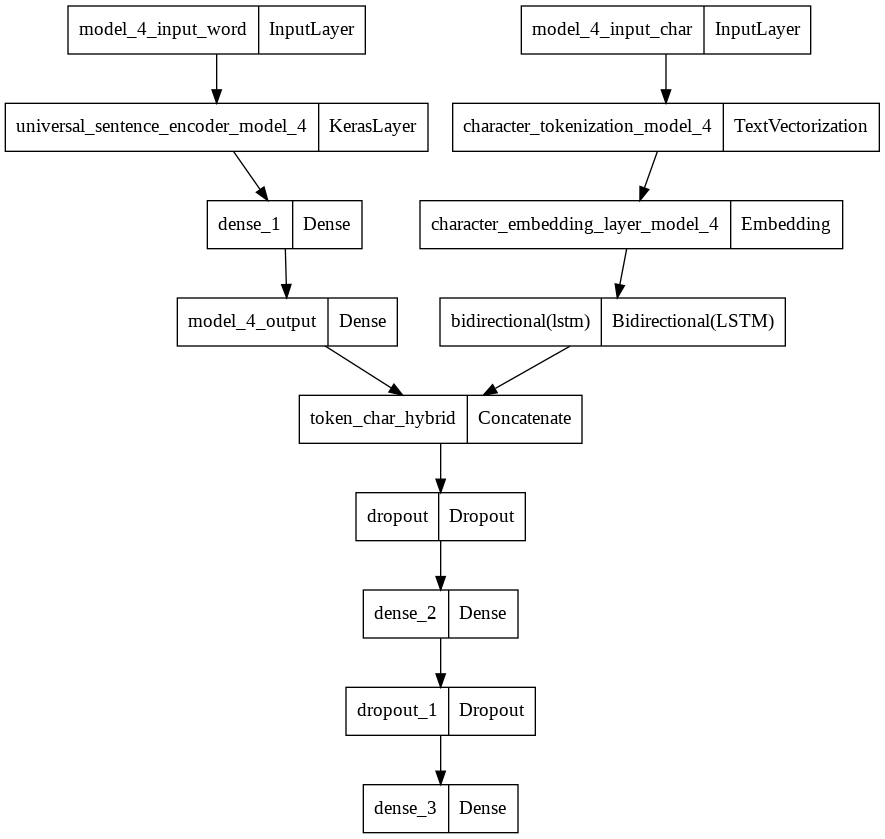

In [61]:
#Plotting the model to check for connections
from tensorflow.keras.utils import plot_model

plot_model(model_4)

In [62]:
#Getting data ready in the forms of tensors
train_word_char_tensors = tf.data.Dataset.from_tensor_slices(((train_char, train_sentences), (train_onehot_labels))).batch(32).prefetch(tf.data.AUTOTUNE)
test_word_char_tensors = tf.data.Dataset.from_tensor_slices(((test_char, test_sentences), (test_onehot_labels))).batch(32).prefetch(tf.data.AUTOTUNE)
val_word_char_tensors = tf.data.Dataset.from_tensor_slices(((val_char, val_sentences), (val_onehot_labels))).batch(32).prefetch(tf.data.AUTOTUNE)

In [63]:
train_word_char_tensors

<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>

In [64]:
#Fitting model
model_4_history = model_4.fit(train_word_char_tensors,
                              epochs = 5,
                              steps_per_epoch = int(0.1*len(train_word_char_tensors)),
                              validation_data = val_word_char_tensors,
                              validation_steps = int(0.1*len(val_word_char_tensors)))

Epoch 1/5
562/562 [==============================] - 90s 138ms/step - loss: 1.2577 - accuracy: 0.4857 - val_loss: 0.9889 - val_accuracy: 0.6383
Epoch 2/5
562/562 [==============================] - 75s 133ms/step - loss: 1.0964 - accuracy: 0.5560 - val_loss: 0.9605 - val_accuracy: 0.6556
Epoch 3/5
562/562 [==============================] - 70s 124ms/step - loss: 1.0738 - accuracy: 0.5715 - val_loss: 0.9648 - val_accuracy: 0.6626
Epoch 4/5
562/562 [==============================] - 76s 136ms/step - loss: 1.0373 - accuracy: 0.5971 - val_loss: 0.9374 - val_accuracy: 0.6818
Epoch 5/5
562/562 [==============================] - 72s 128ms/step - loss: 1.0254 - accuracy: 0.5969 - val_loss: 0.9555 - val_accuracy: 0.6858


In [65]:
#Evaluation
model_4.evaluate(test_word_char_tensors) #[0.9869252443313599, 0.6193234920501709]

945/945 [==============================] - 54s 57ms/step - loss: 0.9570 - accuracy: 0.6851


[0.9570454955101013, 0.6851251125335693]

In [66]:
#predicting
model_4_pred_probs = model_4.predict(val_word_char_tensors)

model_4_preds = np.argmax(model_4_pred_probs, axis=1)

model_4_results = calculate_scores(val_labenc_labels, model_4_preds)
model_4_results

{'accuracy': 67.88451966152314,
 'f1': 0.6620600534111222,
 'precision': 0.6734068017656389,
 'recall': 0.6788451966152315}

**Model 5: Deep learning with word (transfer learning), character and positional embedding.**

In [67]:
#importing pretrained layers
pretrained_embedding_model_5 = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False, 
                                        name="universal_sentence_encoder_model_5")

In [68]:
#defining pretrained layer model for word embeddings
input_word = layers.Input(shape=[], dtype=tf.string, name='model_5_input_word')
pretrained_embedding_layer_model_5 = pretrained_embedding_model_5(input_word)
x = layers.Dense(128, activation='relu')(pretrained_embedding_layer_model_5)
output_word = layers.Dense(5, activation='softmax', name='model_5_output')(x)

model_5_word_embedding = tf.keras.Model(input_word, output_word)

In [69]:
#Inititalizing character level tokeniztion
character_tokenization_model_5 = layers.TextVectorization(max_tokens = max_char_tokens,
                                                          standardize = 'lower_and_strip_punctuation',
                                                          output_sequence_length = output_char_sequence_length,
                                                          name = 'character_tokenization_model_5')
character_tokenization_model_5.adapt(train_sentences)

In [70]:
#Defning character embedding layer and the model
embedding_model_5 = Embedding(
    input_dim = max_char_tokens, 
    output_dim = 64, mask_zero=True, 
    input_length=output_char_sequence_length,
    name = 'character_embedding_layer_model_5')

input_char = layers.Input(shape=(1,), dtype=tf.string, name = 'model_5_input_char')
character_tokenization_layer_model_5 = character_tokenization_model_5(input_char)
embedding_layer_model_5 = embedding_model_4(character_tokenization_layer_model_5)
output_char = layers.Bidirectional(layers.LSTM(25))(embedding_layer_model_5)

model_5_character_embedding = tf.keras.Model(input_char, output_char)

In [71]:
#Concatinating the word and character embedding models
concated_layer = tf.keras.layers.Concatenate(name="token_char_hybrid")([model_5_word_embedding.output, model_5_character_embedding.output])

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: Line_number, dtype: int64

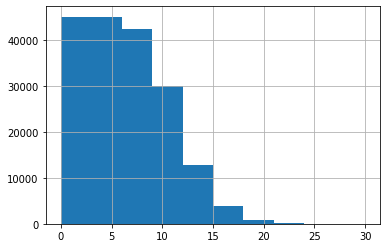

In [72]:
train_df['Line_number'].hist()
train_df['Line_number'].value_counts()

In [73]:
#Getting one hot tensors for line number of abstracts
train_line_number_onehot = tf.one_hot(train_df['Line_number'], 
                                      depth = 15, #based on data distribution
                                        )

val_line_number_onehot = tf.one_hot(val_df['Line_number'], 
                                      depth = 15, #based on data distribution
                                        )

test_line_number_onehot = tf.one_hot(test_df['Line_number'], 
                                      depth = 15, #based on data distribution
                                        )
train_line_number_onehot

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [74]:
#Defining model for line numbers
input_line_number = layers.Input(shape=(15,), dtype=tf.float32, name = 'model_5_input_line_number')
x = layers.Dense(32, activation="relu")(input_line_number)
model_5_line_number = tf.keras.Model(inputs=input_line_number,
                                   outputs=x)

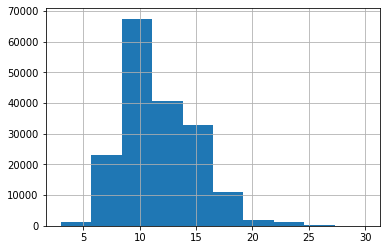

In [75]:
train_df['total_lines'].hist()

In [76]:
#Getting tensors for total lines of abstracts
train_total_lines_onehot = tf.one_hot(
    train_df['total_lines'], 
    depth = 20, #based on data distribution
   )

val_total_lines_onehot = tf.one_hot(
    val_df['total_lines'], 
    depth = 20, #based on data distribution
   )

test_total_lines_onehot = tf.one_hot(
    test_df['total_lines'], 
    depth = 20, #based on data distribution
   )

train_total_lines_onehot

<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [77]:
#Defning model for total lines
input_total_lines = layers.Input(shape=(20,), dtype=tf.float32, name = 'model_5_input_total_lines')
y = layers.Dense(32, activation="relu")(input_total_lines)
model_5_total_lines = tf.keras.Model(inputs=input_total_lines,
                                   outputs=y)

In [78]:
#Concatinating all the three models
z = layers.Dense(256, activation="relu")(concated_layer)
z = layers.Dropout(0.5)(z)

concated_final_layer = tf.keras.layers.Concatenate(name="token_char_line_hybrid")([model_5_line_number.output, 
                                                                                   model_5_total_lines.output,
                                                                                   z])

In [79]:
#Defining the output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer_model_5")(concated_final_layer)

In [80]:
#Defining the model inputs and outputs 
model_5 = tf.keras.Model([input_word,
                          input_char,
                          input_line_number,
                          input_total_lines], output_layer)

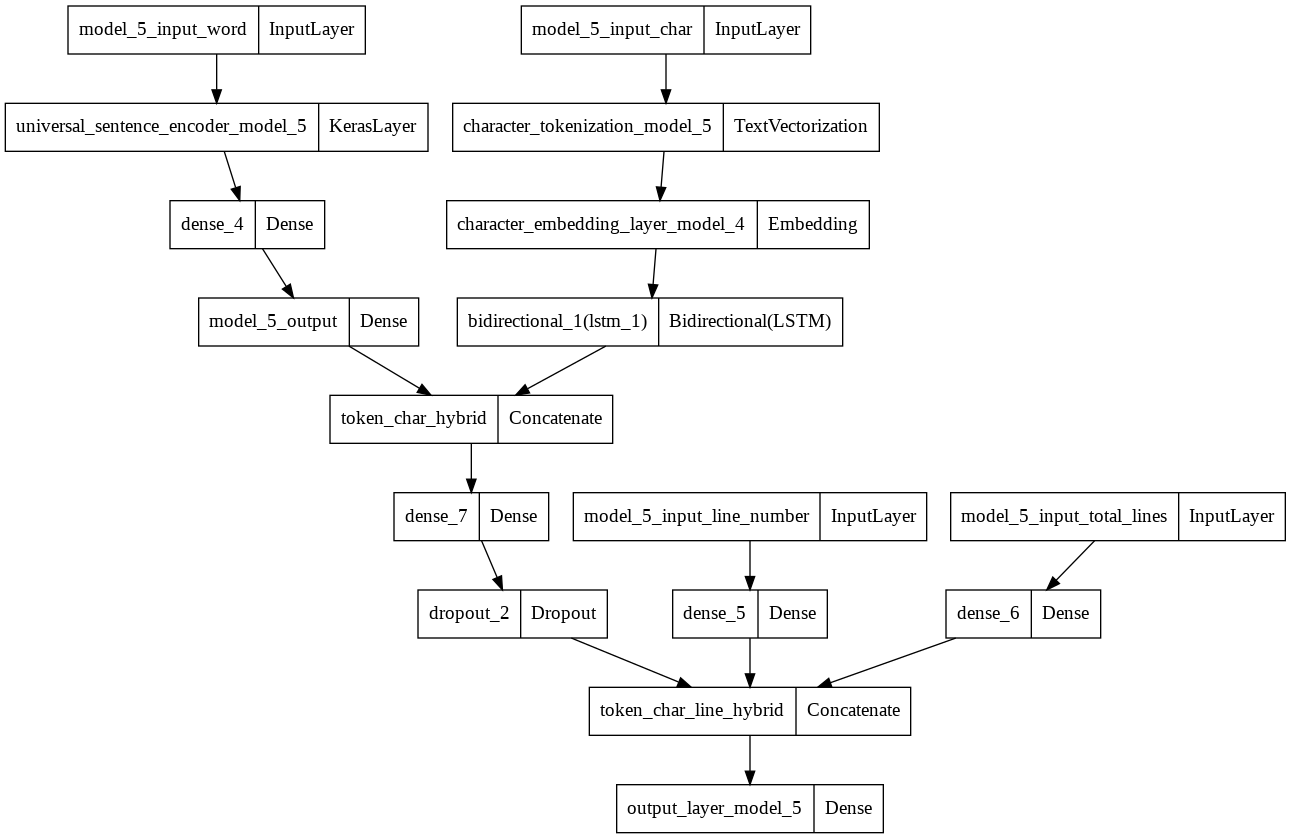

In [81]:
#plotting the model to chech the connections
from tensorflow.keras.utils import plot_model

plot_model(model_5)

In [82]:
#Compiling the model
model_5.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [83]:
#Getting data ready in the form of tensors
train_word_char_line_tensors = tf.data.Dataset.from_tensor_slices(((train_sentences, train_char, train_line_number_onehot, train_total_lines_onehot), (train_onehot_labels))).batch(32).prefetch(tf.data.AUTOTUNE)
test_word_char_line_tensors = tf.data.Dataset.from_tensor_slices(((test_sentences, test_char, test_line_number_onehot, test_total_lines_onehot), (test_onehot_labels))).batch(32).prefetch(tf.data.AUTOTUNE)
val_word_char_line_tensors = tf.data.Dataset.from_tensor_slices(((val_sentences, val_char, val_line_number_onehot, val_total_lines_onehot), (val_onehot_labels))).batch(32).prefetch(tf.data.AUTOTUNE)

In [84]:
#Fitting the model
model_5_history = model_5.fit(train_word_char_line_tensors,
                              epochs = 5,
                              steps_per_epoch = int(0.1*len(train_word_char_line_tensors)),
                              validation_data = val_word_char_line_tensors,
                              validation_steps = int(0.1*len(val_word_char_line_tensors)))

Epoch 1/5
562/562 [==============================] - 92s 141ms/step - loss: 0.8543 - accuracy: 0.6695 - val_loss: 0.6499 - val_accuracy: 0.7443
Epoch 2/5
562/562 [==============================] - 76s 136ms/step - loss: 0.5637 - accuracy: 0.7760 - val_loss: 0.5531 - val_accuracy: 0.7806
Epoch 3/5
562/562 [==============================] - 72s 128ms/step - loss: 0.5149 - accuracy: 0.7896 - val_loss: 0.5335 - val_accuracy: 0.7872
Epoch 4/5
562/562 [==============================] - 78s 139ms/step - loss: 0.4970 - accuracy: 0.8039 - val_loss: 0.4937 - val_accuracy: 0.8112
Epoch 5/5
562/562 [==============================] - 73s 130ms/step - loss: 0.4793 - accuracy: 0.8085 - val_loss: 0.4786 - val_accuracy: 0.8168


In [85]:
#Making predictions
model_5_pred_probs = model_5.predict(val_word_char_line_tensors, verbose=1)
model_5_pred_probs

942/942 [==============================] - 55s 54ms/step


array([[2.6988989e-01, 5.2664713e-03, 7.5959298e-03, 7.1465850e-01,
        2.5891832e-03],
       [4.1182235e-01, 5.4733325e-03, 2.9218683e-01, 2.8507364e-01,
        5.4438184e-03],
       [3.7397447e-03, 1.7503159e-04, 9.7711176e-01, 9.5434915e-03,
        9.4298953e-03],
       ...,
       [2.5878493e-03, 4.2193417e-02, 1.9370049e-02, 1.4842948e-04,
        9.3570024e-01],
       [8.4134834e-03, 7.1293630e-02, 6.6937327e-02, 3.6195360e-04,
        8.5299361e-01],
       [5.6398392e-02, 2.9883283e-01, 2.4519530e-01, 5.2421149e-03,
        3.9433137e-01]], dtype=float32)

In [86]:
#Evaluating
model_5.evaluate(test_word_char_line_tensors) #[0.45094603300094604, 0.8211637735366821]

945/945 [==============================] - 50s 53ms/step - loss: 0.4509 - accuracy: 0.8212


[0.45094603300094604, 0.8211637735366821]

In [87]:
#Calculating scores
model_5_preds = np.argmax(model_5_pred_probs, axis=1)

model_5_results = calculate_scores(val_labenc_labels, model_5_preds)
model_5_results

{'accuracy': 81.50655384104861,
 'f1': 0.8103352647547666,
 'precision': 0.8144710112358302,
 'recall': 0.8150655384104861}

82% accuracy is by far the best performance.

Let's now compare all the models 

In [96]:
all_models_results = pd.DataFrame({
    'base_line_model': model_0_results,
    'word_embedding': model_1_results,
    'pretrained_word_embedding':model_2_results,
    'character_embedding': model_3_results,
    'word_char_embedding': model_4_results,
    'word_char_line_embedding': model_5_results
})

all_models_results = all_models_results.transpose()
all_models_results['accuracy'] = all_models_results['accuracy']/100
all_models_results

,accuracy,precision,recall,f1
base_line_model,0.716675,0.712432,0.716675,0.692510
word_embedding,0.773519,0.772169,0.773519,0.767615
pretrained_word_embedding,0.728256,0.724100,0.728256,0.722848
character_embedding,0.385897,0.254997,0.385897,0.304905
word_char_embedding,0.678845,0.673407,0.678845,0.662060
word_char_line_embedding,0.815066,0.814471,0.815066,0.810335


It can be see that the final model performed the best in all the scores

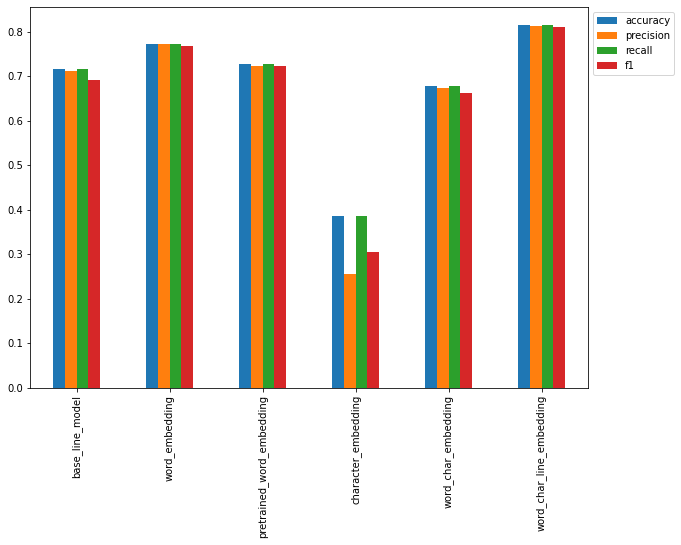

In [99]:
all_models_results.plot(kind = 'bar', figsize = (10,7)).legend(bbox_to_anchor=(1.0, 1.0));

In [106]:
#Saving the best performing model
model_5.save("skimlit_model")

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [118]:
#finding the mosst wronf predictions
model_5_test_preds_probs = model_5.predict(test_word_char_line_tensors, verbose=1)
model_5_test_preds = np.argmax(model_5_test_preds_probs, axis=1)
test_pred_classes = [labelencoder.classes_[pred] for pred in model_5_test_preds]
test_pred_classes

945/945 [==============================] - 52s 55ms/step


['BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'RESULTS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',


In [121]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(model_5_test_preds_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["labels"] # create binary column for whether the prediction is right or not
test_df.head(20)

,labels,Text,Line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,IgE sensitization to Aspergillus fumigatus and...,0,9,BACKGROUND,0.510439,True
1,BACKGROUND,It is not clear whether these patients would b...,1,9,BACKGROUND,0.641354,True
2,OBJECTIVE,We sought to determine whether a @-month cours...,2,9,BACKGROUND,0.473127,False
3,METHODS,Asthmatic patients who were IgE sensitized to ...,3,9,METHODS,0.963334,True
4,METHODS,Primary outcomes were improvement in quality o...,4,9,METHODS,0.879306,True
5,RESULTS,Sixty-five patients were randomized .,5,9,RESULTS,0.560680,True
6,RESULTS,Fifty-nine patients started treatment ( @ rece...,6,9,RESULTS,0.725382,True
7,RESULTS,Fifty-six patients took the full @ months of m...,7,9,RESULTS,0.784257,True
8,RESULTS,"Between the voriconazole and placebo groups , ...",8,9,RESULTS,0.957014,True
9,CONCLUSIONS,We were unable to show a beneficial effect of ...,9,9,CONCLUSIONS,0.855027,True


In [124]:
test_df[test_df.correct == False]

,labels,Text,Line_number,total_lines,prediction,pred_prob,correct
2,OBJECTIVE,We sought to determine whether a @-month cours...,2,9,BACKGROUND,0.473127,False
13,OBJECTIVE,The present pilot study tested the hypothesis ...,3,10,BACKGROUND,0.575782,False
24,OBJECTIVE,We tested the impact of conceptual instruction...,3,10,METHODS,0.866367,False
25,OBJECTIVE,We also examined the learning processes suppor...,4,10,BACKGROUND,0.463293,False
26,METHODS,We worked with @ second - and third-grade chil...,5,10,RESULTS,0.499333,False
...,...,...,...,...,...,...,...
30178,RESULTS,Factors positively associated with DAPT use we...,6,13,METHODS,0.547776,False
30184,CONCLUSIONS,Several correlates of DAPT were identified .,12,13,RESULTS,0.788037,False
30186,BACKGROUND,The objective of this study was to assess the ...,0,11,OBJECTIVE,0.632284,False
30210,CONCLUSIONS,Rates of response to a @-week interferon-free ...,12,13,RESULTS,0.847967,False


In [125]:
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,labels,Text,Line_number,total_lines,prediction,pred_prob,correct
10502,RESULTS,Participants without a previous diagnosis of A...,2,16,METHODS,0.995720,False
20408,RESULTS,"A double-blind , randomized , controlled trial...",2,17,METHODS,0.994100,False
1027,RESULTS,Participants were randomized to tadalafil @ mg...,4,14,METHODS,0.992797,False
16074,RESULTS,Patient-level analyses were conducted using ge...,3,11,METHODS,0.992243,False
10686,CONCLUSIONS,"Additionally , AST resulted in significantly f...",6,7,RESULTS,0.992173,False
...,...,...,...,...,...,...,...
515,RESULTS,A two-compartment model with a first-order abs...,4,11,METHODS,0.968305,False
10312,BACKGROUND,This study aimed to investigate the views and ...,3,14,METHODS,0.968279,False
17997,RESULTS,Key efficacy end points were functional status...,4,16,METHODS,0.968195,False
2253,RESULTS,Infarct size as percentage of total LV mass wa...,3,9,METHODS,0.967657,False


In [126]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: RESULTS, Pred: METHODS, Prob: 0.995719850063324, Line number: 2, Total lines: 16

Text:
Participants without a previous diagnosis of AF underwent intermittent ECG recordings over @ weeks .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9941003918647766, Line number: 2, Total lines: 17

Text:
A double-blind , randomized , controlled trial was conducted at @ sites in the United States .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.992797315120697, Line number: 4, Total lines: 14

Text:
Participants were randomized to tadalafil @ mg daily or placebo for @ months .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9922427535057068, Line number: 3, Total lines: 11

Text:
Patient-level analyses were conducted using generalized estimating equations to account for clustering .

-----

Target: CONCLUSIONS, Pred: RESULTS, Prob: 0.9921731948852539, Line number: 6, Total lines: 7

Text:
Additionally , AST resulted in significantly fewer vessel-to-air exposure events ( P < @ ) and unprote